# Stock Prediction RNN 

In this project, we perform a time series prediction using a Recurrent Neural Network regressor. For this example, we will predict Apple's stock price 7 days in advance.

The particular network architecture we will employ for my RNN is a  [Long Term Short Memory (LTSM)](https://en.wikipedia.org/wiki/Long_short-term_memory), which helps significantly avoid technical problems with optimization of RNNs.

# Pytorch LSTM Stock Predictor

This is a Pytorch version of the original Keras LSTM Stock Predictor provided by [Super DataScience](https://www.superdatascience.com/deep-learning/), and also available elsewhere in this repo as a notebook.

## Step 1: Loading the data

First let's load in our time series - a history of around 140 days of Apple's stock price. Then we need to perform a number of pre-processing steps to prepare it for use with an RNN model.  First off, it is good practice to normalize time series - by normalizing its range.  This helps us avoid serious numerical issues associated how common activation functions (like tanh) transform very large (positive or negative) numbers, as well as helping us to avoid related issues when computing derivatives.

Here we normalize the series to lie in the range [0,1] [using this scikit function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [ ]:
# data source
!wget https://raw.githubusercontent.com/tonylaioffer/stock-prediction-lstm-using-keras/master/data/sandp500/all_stocks_5yr.csv

--2022-12-11 21:05:05--  https://raw.githubusercontent.com/tonylaioffer/stock-prediction-lstm-using-keras/master/data/sandp500/all_stocks_5yr.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29580549 (28M) [text/plain]
Saving to: ‘all_stocks_5yr.csv’

all_stocks_5yr.csv  100%[===================>]  28.21M   116MB/s    in 0.2s    

2022-12-11 21:05:06 (116 MB/s) - ‘all_stocks_5yr.csv’ saved [29580549/29580549]



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Importing the training set
dataset = data = pd.read_csv('./all_stocks_5yr.csv')
dataset_cl = dataset[dataset['Name']=='AAPL'].close.values


In [ ]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))

# Scale the data
dataset_cl = dataset_cl.reshape(dataset_cl.shape[0], 1)
dataset_cl = sc.fit_transform(dataset_cl)

## Step 2:  Cutting our time series into sequences

Remember, our time series is a sequence of numbers that we can represent in general mathematically as 

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="https://github.com/tonylaioffer/stock-prediction-lstm-using-keras/raw/master/images/timeseries_windowing_training.gif" width=600 height=288/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 4 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs.  More generally, for a window size T we create P - T such pairs.

Now let's window the input time series as described above!  

In [ ]:
#Create a function to process the data into 7 day look back slices
def processData(data, lb):
    X, Y = [], []
    for i in range(len(data) - lb - 1):
        X.append(data[i: (i + lb), 0])
        Y.append(data[(i + lb), 0])
    return np.array(X), np.array(Y)
X, y = processData(dataset_cl, 7)


## Step 3: Split training and testing sets

In order to perform proper testing on our dataset we will lop off the last 1/3 of it for validation (or testing).  

Note how here we are **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because our input/output pairs *are related temporally*.   We don't want to validate our model by training on a random subset of the series and then testing on another random subset, as this simulates the scenario that we receive new points *within the timeframe of our training set*.  

We want to train on one solid chunk of the series (in our case, the first full 2/3 of it), and validate on a later chunk (the last 1/3) as this simulates how we would predict *future* values of a time series.

In [ ]:
X_train, X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train, y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

1000
251
1000
251


## Step 4:  Build and run an RNN regression model

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 5 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used

In [ ]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size, dropout=0.1, bidirectional=True):
        super(RNN, self).__init__()
        self.num_directions = bidirectional+1
        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers,
            dropout=dropout,
            bidirectional=bidirectional
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, self.num_directions, hidden_size)
        outs = self.out(r_out)
        
        return outs, hidden_state

In [ ]:
# Globals

INPUT_SIZE = 7
HIDDEN_SIZE = 64
NUM_LAYERS = 3
OUTPUT_SIZE = 1
BATCH_SIZE = 128
# Hyper parameters

learning_rate = 0.001
num_epochs = 300

rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE,bidirectional=False)
rnn.cuda()

optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None

In [ ]:
rnn

RNN(
  (rnn): LSTM(7, 64, num_layers=3, dropout=0.1)
  (out): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
"""
class StockDataset(Dataset):
    
    def __init__(self, X_dataset, Y_dataset):
        
        self.X_dataset = torch.from_numpy(X_dataset)
        self.Y_dataset = torch.from_numpy(Y_dataset)
        
    def __len__(self):
        return np.shape(self.Y_dataset)[0]

    def __getitem__(self, idx):
        
        sample = {'Sequence': self.X_dataset[:,idx,:], "Target": self.Y_dataset[idx]}
      

        return sample
"""

'\nclass StockDataset(Dataset):\n    \n    def __init__(self, X_dataset, Y_dataset):\n        \n        self.X_dataset = torch.from_numpy(X_dataset)\n        self.Y_dataset = torch.from_numpy(Y_dataset)\n        \n    def __len__(self):\n        return np.shape(self.Y_dataset)[0]\n\n    def __getitem__(self, idx):\n        \n        sample = {\'Sequence\': self.X_dataset[:,idx,:], "Target": self.Y_dataset[idx]}\n      \n\n        return sample\n'

In [ ]:
history = []
X_test_cuda = torch.tensor(X_test).float().cuda()
y_test_cuda = torch.tensor(y_test).float().cuda()

inputs_cuda = torch.tensor(X_train).float().cuda()
labels_cuda = torch.tensor(y_train).float().cuda()

for epoch in range(num_epochs):
    rnn.train()
    output, _ = rnn(inputs_cuda, hidden_state) 

    loss = criterion(output[:,0,:].view(-1), labels_cuda)
    optimiser.zero_grad()
    loss.backward()                     # back propagation
    optimiser.step()                    # update the parameters
    
    if epoch % 20 == 0:
        rnn.eval()
        test_output, _ = rnn(X_test_cuda, hidden_state)
        test_loss = criterion(test_output.view(-1), y_test_cuda)
        print('epoch {}, loss {}, eval loss {}'.format(epoch, loss.item(), test_loss.item()))
    else:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
    history.append(loss.item())

epoch 0, loss 0.20136819779872894, eval loss 0.7362908720970154
epoch 1, loss 0.1764204502105713
epoch 2, loss 0.15331296622753143
epoch 3, loss 0.13120372593402863
epoch 4, loss 0.1098647490143776
epoch 5, loss 0.0894739106297493
epoch 6, loss 0.07023130357265472
epoch 7, loss 0.05168323591351509
epoch 8, loss 0.03600466623902321
epoch 9, loss 0.024437611922621727
epoch 10, loss 0.020357511937618256
epoch 11, loss 0.0278313048183918
epoch 12, loss 0.03810717165470123
epoch 13, loss 0.03838399052619934
epoch 14, loss 0.032915011048316956
epoch 15, loss 0.025932956486940384
epoch 16, loss 0.021314771845936775
epoch 17, loss 0.019009042531251907
epoch 18, loss 0.01893657073378563
epoch 19, loss 0.0194623414427042
epoch 20, loss 0.020532332360744476, eval loss 0.18708880245685577
epoch 21, loss 0.021023675799369812
epoch 22, loss 0.021326234564185143
epoch 23, loss 0.020907754078507423
epoch 24, loss 0.019716454669833183
epoch 25, loss 0.018254181370139122
epoch 26, loss 0.016210019588470

In [ ]:
rnn.out.weight 

Parameter containing:
tensor([[-0.0704,  0.0671, -0.0485,  0.1093,  0.1186,  0.0673,  0.0962,  0.0091,
         -0.0008, -0.0183,  0.0036, -0.0640,  0.0240, -0.1026, -0.1093,  0.1200,
          0.0860,  0.1084,  0.0233,  0.0045,  0.0209, -0.0863, -0.1191,  0.1253,
         -0.1065,  0.0077, -0.0948, -0.1107,  0.0946, -0.0475,  0.0170,  0.0096,
         -0.0979, -0.0133,  0.0689, -0.0262, -0.0229,  0.1278,  0.0629,  0.1292,
          0.1014, -0.0914,  0.0043,  0.0389, -0.0180,  0.0294,  0.0838,  0.0256,
         -0.1249, -0.0291, -0.0062,  0.1069, -0.0586, -0.0955, -0.0655, -0.0771,
         -0.0674, -0.0983,  0.0200, -0.0596,  0.0576,  0.0383, -0.0309,  0.0782]],
       device='cuda:0', requires_grad=True)

In [ ]:
for param in rnn.parameters():
    print(param.data)

tensor([[-0.1021, -0.0743, -0.1002,  ...,  0.0054, -0.0302, -0.0281],
        [ 0.1246,  0.1434, -0.0344,  ...,  0.1109,  0.1130,  0.0866],
        [ 0.0838, -0.0111,  0.0016,  ...,  0.0626,  0.0391, -0.0370],
        ...,
        [ 0.1319,  0.1528,  0.0446,  ..., -0.0830, -0.0304,  0.0956],
        [ 0.1053,  0.1455,  0.0227,  ...,  0.1156,  0.0058,  0.1441],
        [-0.0877, -0.0582, -0.0237,  ..., -0.0349, -0.0060,  0.0129]],
       device='cuda:0')
tensor([[-0.0514, -0.0870,  0.0217,  ..., -0.0440,  0.0189, -0.0073],
        [-0.0422, -0.0158,  0.1131,  ...,  0.0319,  0.0902, -0.0624],
        [-0.0513, -0.0241, -0.0901,  ..., -0.0344,  0.0290, -0.0173],
        ...,
        [ 0.0593,  0.0104,  0.1073,  ...,  0.1144, -0.0377, -0.0635],
        [-0.0355, -0.0811, -0.0989,  ..., -0.0859,  0.0848, -0.0853],
        [ 0.0416,  0.0570, -0.0184,  ...,  0.0432,  0.0206,  0.0874]],
       device='cuda:0')
tensor([-0.0111,  0.0176, -0.0311,  0.0912,  0.0492, -0.0192, -0.0825,  0.1154,
    

## Step 5: Checking model performance

With our model fit we can now make predictions on both our training and testing sets.

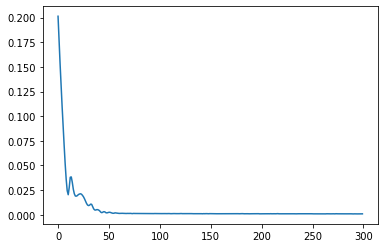

In [ ]:
plt.plot(history)

In [ ]:
X_test[0]

array([[0.53324732, 0.53097957, 0.5909131 , 0.5891313 , 0.59358582,
        0.60338576, 0.61342868]])

In [ ]:
rnn.eval()
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

In [ ]:
test_predict_cpu.shape

(251, 1, 1)

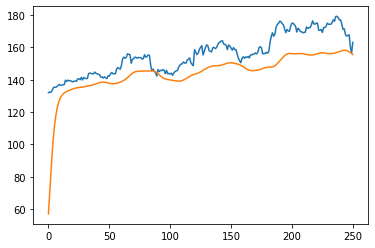

In [ ]:
plt.plot(sc.inverse_transform(y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(test_predict_cpu.reshape(-1,1)))

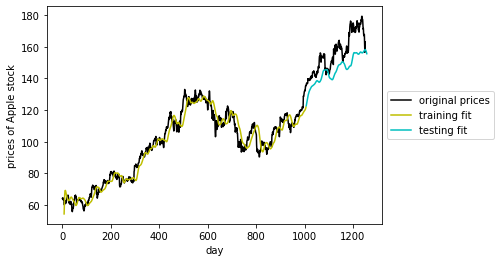

In [ ]:
# Plot original data
plt.plot(sc.inverse_transform(y.reshape(-1,1)), color='k')

train_pred, hidden_state = rnn(inputs_cuda, None)
train_pred_cpu = train_pred.cpu().detach().numpy()

# Use hidden state from previous training data
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

split_pt = int(X.shape[0] * 0.80) + 7 
plt.plot(np.arange(7, split_pt, 1), sc.inverse_transform(train_pred_cpu.reshape(-1,1)), color='y')
plt.plot(np.arange(split_pt, split_pt + len(test_predict_cpu), 1), sc.inverse_transform(test_predict_cpu.reshape(-1,1)), color='c')

# Plot the final graph
plt.xlabel('day')
plt.ylabel('prices of Apple stock')
plt.legend(['original prices','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
